## DC House Price

#### Project goal: 

- Predict the median house price in DC
- use the right housing statistics and macro variables: (1) time series, (2) acf/pacf plots, (3) stationary test and (4) autocorrelation test
- Modeling: time series linear regression: feature selection in R-squared, AIC, etc.
- Cross validation: Out-of-time performance
- Residual analysis: (1) normality test, (2) Q-Q plot, (3) MAE, (4) MAPE, (5) Homoscedastic test, (6) stationary test and (7) autocorrelation test 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.compat import lzip

%matplotlib inline

In [2]:
# feature selection: KBest using f_regression, chi2, mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2, mutual_info_regression

# tests for stationary 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

import statsmodels.api as sm

#tests for autocorrelation
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

#test of Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_goldfeldquandt

#test for cointegration
from statsmodels.tsa.vector_ar.vecm import coint_johansen 

In [3]:
df = pd.read_csv("../data/full_data.csv")

In [4]:
df.tail()

,Time,Median Sale Price,Median Sale Price MoM,Homes Sold,Homes Sold MoM,New Listings,New Listings MoM,Inventory,Inventory MoM,Days on Market,...,WDXRSA,US_UR,DMV_UR,DC_UR,FED_EM,FIN_EM,HOS_EM,DC_PER,DMV_PER,DMV_PER_1
112,2019-Jun,325000.0,2.5,1089.0,-9.3,1162.0,-20.2,1752.0,0.2,20,...,232.112524,3.7,3.4,5.6,363.193444,103.253989,347.332822,389.0,2036.740005,1178.709018
113,2019-Jul,318000.0,-2.2,1094.0,0.5,1172.0,0.9,1694.0,-3.3,22,...,232.032415,3.7,3.3,5.6,363.391729,102.106994,347.357406,455.0,2056.199932,1138.927749
114,2019-Aug,300000.0,-5.7,1074.0,-1.8,972.0,-17.1,1540.0,-9.1,25,...,232.650097,3.7,3.2,5.5,364.342848,102.964051,350.489560,437.0,2000.434352,1247.029523
115,2019-Sep,315000.0,5.0,888.0,-17.3,1218.0,25.3,1692.0,9.9,25,...,233.380305,3.5,2.9,5.4,363.321499,102.012584,352.846320,329.0,2083.453745,1429.372493
116,2019-Oct,330000.0,4.7,982.0,10.6,1100.0,-9.7,1735.0,2.5,25,...,234.644022,3.6,2.8,5.4,363.261555,103.049750,355.226651,1395.0,2651.639321,1163.982510


In [5]:
df_test = df.drop(columns=['Time', 'DATE', 'Median Sale Price MoM', 'New Listings MoM', 'Homes Sold MoM', 'Inventory MoM', 'Days on Market MoM', 'Average Sale To List MoM', 'DC_PER'])
col_name = df_test.columns

In [6]:
# create a log transformed variable
for i in range(len(col_name)):
    df[col_name[i] + '_log'] =  np.log(df[col_name[i]])

In [7]:
df_test = df.drop(columns=['Time', 'DATE'])
col_name = df_test.columns
col_name

Index(['Median Sale Price', 'Median Sale Price MoM', 'Homes Sold',
       'Homes Sold MoM', 'New Listings', 'New Listings MoM', 'Inventory',
       'Inventory MoM', 'Days on Market', 'Days on Market MoM',
       'Average Sale To List%', 'Average Sale To List MoM', 'WDXRSA', 'US_UR',
       'DMV_UR', 'DC_UR', 'FED_EM', 'FIN_EM', 'HOS_EM', 'DC_PER', 'DMV_PER',
       'DMV_PER_1', 'Median Sale Price_log', 'Homes Sold_log',
       'New Listings_log', 'Inventory_log', 'Days on Market_log',
       'Average Sale To List%_log', 'WDXRSA_log', 'US_UR_log', 'DMV_UR_log',
       'DC_UR_log', 'FED_EM_log', 'FIN_EM_log', 'HOS_EM_log', 'DMV_PER_log',
       'DMV_PER_1_log'],
      dtype='object')

In [8]:
def difference(dataset, interval = 1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

In [9]:
df1 = pd.DataFrame(df['Time'][1:117])
# create a log transformed variable
for i in range(len(col_name)):
    df1[col_name[i] + '_1diff'] = difference(df[col_name[i]])

In [10]:
df1

,Time,Median Sale Price_1diff,Median Sale Price MoM_1diff,Homes Sold_1diff,Homes Sold MoM_1diff,New Listings_1diff,New Listings MoM_1diff,Inventory_1diff,Inventory MoM_1diff,Days on Market_1diff,...,Average Sale To List%_log_1diff,WDXRSA_log_1diff,US_UR_log_1diff,DMV_UR_log_1diff,DC_UR_log_1diff,FED_EM_log_1diff,FIN_EM_log_1diff,HOS_EM_log_1diff,DMV_PER_log_1diff,DMV_PER_1_log_1diff
1,2010-Mar,-13000.0,-16.3,265.0,54.8,596.0,57.2,324.0,3.2,-9,...,0.000000,-0.003139,0.010152,-0.029414,-0.020834,0.001249,0.002790,0.016275,-0.192304,-0.115160
2,2010-Apr,23000.0,14.9,123.0,-35.3,38.0,-52.6,222.0,-3.7,-14,...,-0.001019,0.011589,0.000000,-0.093819,-0.010582,0.004076,-0.002135,0.014622,0.037911,0.079167
3,2010-May,-10000.0,-13.5,79.0,-6.9,-690.0,-42.4,-18.0,-6.5,2,...,-0.001020,0.005486,-0.030772,0.032261,-0.010695,0.023673,0.002529,-0.008461,-0.149028,-0.203737
4,2010-Jun,-10000.0,-0.2,-26.0,-11.3,231.0,62.5,33.0,1.4,5,...,0.000000,0.005211,-0.021053,0.031253,0.000000,-0.001574,0.002504,0.004022,0.088073,0.172807
5,2010-Jul,0.0,4.0,-286.0,-27.1,-150.0,-34.3,-36.0,-1.8,10,...,-0.002043,-0.001088,0.000000,-0.015504,-0.010811,-0.001504,0.001281,-0.000768,0.064944,0.008507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2019-Jun,8000.0,2.1,-111.0,-15.2,-295.0,-27.1,3.0,-6.8,0,...,-0.002002,0.001236,0.027399,0.092373,-0.017700,0.000038,0.006848,0.005231,-0.123683,-0.114050
113,2019-Jul,-7000.0,-4.7,5.0,9.8,10.0,21.1,-58.0,-3.5,2,...,0.002002,-0.000345,0.000000,-0.029853,0.000000,0.000546,-0.011171,0.000071,0.009509,-0.034333
114,2019-Aug,-18000.0,-3.5,-20.0,-2.3,-200.0,-18.0,-154.0,-5.8,3,...,-0.003005,0.002659,0.000000,-0.030772,-0.018019,0.002614,0.008359,0.008977,-0.027495,0.090677
115,2019-Sep,15000.0,10.7,-186.0,-15.5,246.0,42.4,152.0,19.0,0,...,-0.003014,0.003134,-0.055570,-0.098440,-0.018349,-0.002807,-0.009284,0.006702,0.040663,0.136471


In [11]:
col_name1 = df1.drop(columns=['Time']).columns
col_name1

Index(['Median Sale Price_1diff', 'Median Sale Price MoM_1diff',
       'Homes Sold_1diff', 'Homes Sold MoM_1diff', 'New Listings_1diff',
       'New Listings MoM_1diff', 'Inventory_1diff', 'Inventory MoM_1diff',
       'Days on Market_1diff', 'Days on Market MoM_1diff',
       'Average Sale To List%_1diff', 'Average Sale To List MoM_1diff',
       'WDXRSA_1diff', 'US_UR_1diff', 'DMV_UR_1diff', 'DC_UR_1diff',
       'FED_EM_1diff', 'FIN_EM_1diff', 'HOS_EM_1diff', 'DC_PER_1diff',
       'DMV_PER_1diff', 'DMV_PER_1_1diff', 'Median Sale Price_log_1diff',
       'Homes Sold_log_1diff', 'New Listings_log_1diff', 'Inventory_log_1diff',
       'Days on Market_log_1diff', 'Average Sale To List%_log_1diff',
       'WDXRSA_log_1diff', 'US_UR_log_1diff', 'DMV_UR_log_1diff',
       'DC_UR_log_1diff', 'FED_EM_log_1diff', 'FIN_EM_log_1diff',
       'HOS_EM_log_1diff', 'DMV_PER_log_1diff', 'DMV_PER_1_log_1diff'],
      dtype='object')

#### Only focus on KPSS and DW test

In [12]:
# %load ../python_folder/python_files/test_matrix_kpss_dw

In [12]:
def hypo_test(col_name = col_name, data = df):
    # p-value for adfuller
    p_val_adf = []
    
    # p-value for kpss
    p_val_kpss = []

    # p-value for acorr_breusch_godfrey 
    p_val_bg = []

    # p-value for Ljung–Box Q test
    p_val_lj = []

    # statistic for durbin_watson
    stat_dw = []
    for i in range(len(col_name)):
        temp = adfuller(data[col_name[i]], regression = 'ct')
        p_val_adf.append(temp[1])
    
        temp = kpss(data[col_name[i]], regression = 'ct')
        p_val_kpss.append(temp[1])
    
        temp = acorr_ljungbox(data[col_name[i]], lags = 10)
        p_val_lj.append(temp[1][0])
    
        temp = durbin_watson(data[col_name[i]])
        stat_dw.append(temp)
        
    test_matrix = pd.DataFrame(list(zip(col_name, p_val_adf, p_val_kpss, p_val_lj, stat_dw)), 
               columns =['Features','p_adftest', 'p_kpsstest','p_ljtest', 'stat_dw'])
    return test_matrix

In [13]:
test_matrix = hypo_test(col_name = col_name, data = df)

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cs

In [14]:
test_matrix1 = hypo_test(col_name = col_name1, data = df1)

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarni

In [16]:
test_p_value(p = .05, name = 'adftest', data = test_matrix1)
test_p_value(p = .05, name = 'kpsstest', data = test_matrix1)
test_p_value(p = .05, name = 'ljtest', data = test_matrix1)
test_matrix1

,Features,p_adftest,p_kpsstest,p_ljtest,stat_dw,index_adftest,index_kpsstest,index_ljtest
0,Median Sale Price_1diff,5.756461e-07,0.100000,1.310414e-02,2.415474,1,0,1
1,Median Sale Price MoM_1diff,2.559160e-09,0.100000,7.077911e-10,3.072374,1,0,1
2,Homes Sold_1diff,2.490141e-02,0.100000,6.191140e-01,2.049703,1,0,0
3,Homes Sold MoM_1diff,1.259473e-14,0.100000,1.167559e-08,2.986549,1,0,1
4,New Listings_1diff,4.369070e-02,0.100000,3.538157e-01,1.770372,1,0,0
5,New Listings MoM_1diff,8.158924e-19,0.100000,3.632187e-07,2.904540,1,0,1
6,Inventory_1diff,9.060760e-01,0.100000,4.485650e-07,1.033034,0,0,1
7,Inventory MoM_1diff,3.018430e-02,0.100000,4.801663e-01,2.120688,1,0,0
8,Days on Market_1diff,2.690690e-01,0.100000,5.200277e-03,1.474804,0,0,1
9,Days on Market MoM_1diff,5.671379e-17,0.100000,1.516133e-02,2.443468,1,0,1


In [17]:
index_kpss = test_matrix1['index_kpsstest'] == 0
index_lj = test_matrix1['index_ljtest'] == 0
index_dw1 = test_matrix1['stat_dw'] >= .9 
index_dw2 = test_matrix1['stat_dw'] <= 3.1 
index_adf = test_matrix1['index_ljtest'] == 1
test_col1 = list(test_matrix1[index_kpss & index_lj]["Features"])
test_col1

['Homes Sold_1diff',
 'New Listings_1diff',
 'Inventory MoM_1diff',
 'Average Sale To List%_1diff',
 'DMV_UR_1diff',
 'FED_EM_1diff',
 'HOS_EM_1diff',
 'Homes Sold_log_1diff',
 'New Listings_log_1diff',
 'Average Sale To List%_log_1diff',
 'DMV_UR_log_1diff',
 'FED_EM_log_1diff',
 'HOS_EM_log_1diff']

In [18]:
test_col1 = list(test_matrix1[index_adf & index_kpss & index_dw1 & index_dw2]["Features"])
#test_col1 = list(test_matrix1[index_adf]["Features"])
test_col1

['Median Sale Price_1diff',
 'Median Sale Price MoM_1diff',
 'Homes Sold MoM_1diff',
 'New Listings MoM_1diff',
 'Inventory_1diff',
 'Days on Market_1diff',
 'Days on Market MoM_1diff',
 'WDXRSA_1diff',
 'US_UR_1diff',
 'FIN_EM_1diff',
 'DC_PER_1diff',
 'DMV_PER_1diff',
 'DMV_PER_1_1diff',
 'Median Sale Price_log_1diff',
 'Inventory_log_1diff',
 'Days on Market_log_1diff',
 'WDXRSA_log_1diff',
 'US_UR_log_1diff',
 'FIN_EM_log_1diff',
 'DMV_PER_log_1diff',
 'DMV_PER_1_log_1diff']

In [24]:
test_matrix1.to_csv('../data/TM_test_1diff.csv')

In [19]:
test_col1.remove('Median Sale Price_1diff')
test_col1.remove('Median Sale Price_log_1diff')
test_col1.remove('Median Sale Price MoM_1diff')
#'Median Sale Price MoM_1diff'
test_col1

['Homes Sold MoM_1diff',
 'New Listings MoM_1diff',
 'Inventory_1diff',
 'Days on Market_1diff',
 'Days on Market MoM_1diff',
 'WDXRSA_1diff',
 'US_UR_1diff',
 'FIN_EM_1diff',
 'DC_PER_1diff',
 'DMV_PER_1diff',
 'DMV_PER_1_1diff',
 'Inventory_log_1diff',
 'Days on Market_log_1diff',
 'WDXRSA_log_1diff',
 'US_UR_log_1diff',
 'FIN_EM_log_1diff',
 'DMV_PER_log_1diff',
 'DMV_PER_1_log_1diff']

In [ ]:
# %load ../python_folder/python_files/Test_p_value

In [15]:
# Create a function to detect the hypothesis testing results. 1: reject null, 0: fail to reject null
def test_p_value(p = .05, name = 'ttest', data = test_matrix):
    name_list = []
    for i in range(len(test_matrix)):
        if data["p_" + name][i] < p:
            name_list.append(1) 
        else:
            name_list.append(0)   
    data['index_' + name] = name_list

In [20]:
test_p_value(p = .05, name = 'adftest')
test_p_value(p = .05, name = 'kpsstest')
test_p_value(p = .05, name = 'ljtest')
test_matrix

,Features,p_adftest,p_kpsstest,p_ljtest,stat_dw,index_adftest,index_kpsstest,index_ljtest
0,Median Sale Price,1.852913e-03,0.048158,5.860334e-23,1.460217e-03,1,1,1
1,Median Sale Price MoM,4.774490e-07,0.100000,1.510148e-02,2.351027e+00,1,0,1
2,Homes Sold,9.371101e-01,0.100000,5.742783e-16,2.136036e-02,0,0,1
3,Homes Sold MoM,7.690392e-02,0.100000,7.062849e-01,2.040086e+00,0,0,0
4,New Listings,9.164763e-01,0.100000,3.455617e-13,4.232778e-02,0,0,1
5,New Listings MoM,4.836519e-01,0.100000,9.330193e-01,1.955755e+00,0,0,0
6,Inventory,1.227744e-02,0.085247,3.028106e-25,5.105290e-03,1,0,1
7,Inventory MoM,9.186213e-01,0.100000,3.047694e-07,1.057099e+00,0,0,1
8,Days on Market,4.751578e-02,0.100000,1.495454e-19,4.371311e-02,1,0,1
9,Days on Market MoM,2.668512e-01,0.100000,4.162127e-03,1.471667e+00,0,0,1


In [27]:
# Save the final testing results in data folder
test_matrix.to_csv('../data/TM_test.csv')

In [21]:
# Find all features are stationary and autocorrelation 0 based on both KPSS and DW tests
index_adf = test_matrix['index_adftest'] == 1
index_kpss = test_matrix['index_kpsstest'] == 0
index_lj = test_matrix['index_ljtest'] == 0
index_dw1 = test_matrix['stat_dw'] >= .9
index_dw2 = test_matrix['stat_dw'] <= 3.1 
test_col = list(test_matrix[index_kpss & index_lj]["Features"])
test_col

['Homes Sold MoM', 'New Listings MoM', 'Average Sale To List MoM']

In [22]:
index_dw1 = test_matrix['stat_dw'] >= .9
index_dw2 = test_matrix['stat_dw'] <= 3.1 
test_col = list(test_matrix[index_adf & index_kpss]["Features"])
#test_col = list(test_matrix[index_kpss]["Features"])
test_col

['Median Sale Price MoM',
 'Inventory',
 'Days on Market',
 'DC_PER',
 'Inventory_log',
 'Days on Market_log']

In [23]:
test_col.remove('Median Sale Price MoM')
test_col

['Inventory',
 'Days on Market',
 'DC_PER',
 'Inventory_log',
 'Days on Market_log']

#### Split In-Time and Out-of-Time samples 

In [24]:
#df[test_col][1:100]
#df[test_col][100:117]

In [25]:
#df1[test_col1][:99]
#df1[test_col1][99:116]

In [270]:
train_x.head()

,Inventory,Days on Market,DC_PER,Inventory_log,Days on Market_log,Homes Sold MoM_1diff,New Listings MoM_1diff,Inventory_1diff,Days on Market_1diff,Days on Market MoM_1diff,...,DC_PER_1diff,DMV_PER_1diff,DMV_PER_1_1diff,Inventory_log_1diff,Days on Market_log_1diff,WDXRSA_log_1diff,US_UR_log_1diff,FIN_EM_log_1diff,DMV_PER_log_1diff,DMV_PER_1_log_1diff
1,3670.0,42,27.0,8.207947,3.737670,54.8,57.2,324.0,-9,-4.0,...,-33.0,-253.258138,-89.398023,0.092426,-0.194156,-0.003139,0.010152,0.002790,-0.192304,-0.115160
2,3892.0,28,166.0,8.266678,3.332205,-35.3,-52.6,222.0,-14,-5.0,...,139.0,46.150517,60.343027,0.058732,-0.405465,0.011589,0.000000,-0.002135,0.037911,0.079167
3,3874.0,30,15.0,8.262043,3.401197,-6.9,-42.4,-18.0,2,16.0,...,-151.0,-171.759123,-146.130022,-0.004636,0.068993,0.005486,-0.030772,0.002529,-0.149028,-0.203737
4,3907.0,35,8.0,8.270525,3.555348,-11.3,62.5,33.0,5,3.0,...,-7.0,98.400750,121.984112,0.008482,0.154151,0.005211,-0.021053,0.002504,0.088073,0.172807
5,3871.0,45,140.0,8.261268,3.806662,-27.1,-34.3,-36.0,10,5.0,...,132.0,78.317759,6.567065,-0.009257,0.251314,-0.001088,0.000000,0.001281,0.064944,0.008507


In [29]:
train_x = pd.concat([df[test_col][1:100], df1[test_col1][0:99]], axis=1)
test_x = pd.concat([df[test_col][100:117], df1[test_col1][99:116]], axis=1)
train_y = df["Median Sale Price MoM"][1:100]
test_y = df["Median Sale Price MoM"][99:116]

In [26]:
#final one
train_x = pd.concat([df[test_col][1:100], df1[test_col1][0:99]], axis=1)
test_x = pd.concat([df[test_col][100:117], df1[test_col1][99:116]], axis=1)
train_y = df1["Median Sale Price_1diff"][0:99]
test_y = df1["Median Sale Price_1diff"][99:116]

In [83]:
train_x = pd.concat([df[test_col][1:100], df1[test_col1][0:99]], axis=1)
test_x = pd.concat([df[test_col][100:117], df1[test_col1][99:116]], axis=1)
train_y = df1["Median Sale Price MoM_1diff"][0:99]
test_y = df1["Median Sale Price MoM_1diff"][99:116]

In [95]:
train_x = pd.concat([df[test_col][1:100], df1[test_col1][0:99]], axis=1)
test_x = pd.concat([df[test_col][100:117], df1[test_col1][99:116]], axis=1)
train_y = df1['Median Sale Price_log_1diff'][0:99]
test_y = df1['Median Sale Price_log_1diff'][99:116]

In [ ]:
# feature selection: forward/backward stepwise regression and KBest

In [28]:
result = stepwise_selection(train_x, train_y, threshold_in = 0.1, threshold_out = 0.15)

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  Days on Market_1diff           with p-value 2.3446e-07
Add  US_UR_1diff                    with p-value 0.0253127
Add  New Listings MoM_1diff         with p-value 0.0110349


In [29]:
print('resulting features:')
print(result)

resulting features:
['Days on Market_1diff', 'US_UR_1diff', 'New Listings MoM_1diff']


In [ ]:
# %load ../python_folder/python_files/ForwardBackwardStepwiseRegression

In [27]:
#from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm

#data = load_boston()
#X = pd.DataFrame(data.data, columns=data.feature_names)
#y = data.target


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin() # change argmin to idxmin
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#result = stepwise_selection(X, y)

#print('resulting features:')
#print(result)

In [ ]:
# %load ../python_folder/python_files/KBest

In [30]:
# Feature selection using KBest with f_regreesion
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectkbest#sklearn.feature_selection.SelectKBest

from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2
bestfeatures = SelectKBest(score_func = f_regression , k = 10)
fit = bestfeatures.fit(train_x,train_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                       Specs      Score
8       Days on Market_1diff  30.948306
17  Days on Market_log_1diff  27.056123
9   Days on Market MoM_1diff  12.113787
6     New Listings MoM_1diff   9.516109
16       Inventory_log_1diff   5.386566
11               US_UR_1diff   5.164173
7            Inventory_1diff   5.150628
4         Days on Market_log   4.441379
5       Homes Sold MoM_1diff   4.353864
1             Days on Market   4.061645


In [31]:
col_kbest = list(featureScores.nlargest(10,'Score')['Specs'])

In [32]:
col_kbest.remove('Days on Market_1diff')
col_kbest.remove('Days on Market_log_1diff')
col_kbest.remove('Homes Sold_1diff')
col_kbest.remove('Homes Sold MoM')
col_kbest.remove('Days on Market MoM_1diff')
col_kbest.remove('Average Sale To List%_1diff')

ValueError: list.remove(x): x not in list

In [33]:
col_kbest

['Days on Market MoM_1diff',
 'New Listings MoM_1diff',
 'Inventory_log_1diff',
 'US_UR_1diff',
 'Inventory_1diff',
 'Days on Market_log',
 'Homes Sold MoM_1diff',
 'Days on Market']

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2, mutual_info_regression
bestfeatures = SelectKBest(score_func = mutual_info_regression , k = 10) # 
fit = bestfeatures.fit(train_x,train_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

In [ ]:
#sel_x = train_x[['Days on Market MoM', 'Days on Market_1diff', 'US_UR_1diff', 'New Listings MoM_1diff', 'DMV_UR_log_1diff']]

In [34]:
# run time series model

#sel_x = train_x[['WDXRSA_log', 'Days on Market', 'FIN_EM', 'DC_UR_log']]

sel_x = train_x[['Days on Market_1diff', 'US_UR_1diff', 'New Listings MoM_1diff', 'WDXRSA_1diff']]

#sel_x = train_x[['Days on Market_1diff', 'Days on Market MoM', 'US_UR_1diff', 'New Listings MoM_1diff', 'DMV_UR_log_1diff', 'Average Sale To List MoM_1diff', 'DMV_PER_1diff', 'WDXRSA_1diff']]
#sel_x = train_x[['Days on Market_1diff', 'Days on Market MoM', 'US_UR_1diff', 'New Listings MoM_1diff', 'DMV_UR_log_1diff', 'Average Sale To List MoM_1diff', 'DMV_PER_1diff', 'WDXRSA_1diff']]


#sel_x = train_x[['Days on Market MoM_1diff', 'New Listings MoM_1diff', 'DMV_PER_log_1diff', 'WDXRSA_1diff']]
train_X = sm.add_constant(sel_x)
mod = sm.OLS(train_y, train_X, hasconst= True)
res = mod.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     Median Sale Price_1diff   R-squared:                       0.337
Model:                                 OLS   Adj. R-squared:                  0.309
Method:                      Least Squares   F-statistic:                     11.94
Date:                     Mon, 17 Feb 2020   Prob (F-statistic):           6.88e-08
Time:                             22:24:53   Log-Likelihood:                -1039.7
No. Observations:                       99   AIC:                             2089.
Df Residuals:                           94   BIC:                             2102.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(sel_x.values, i) for i in range(sel_x.shape[1])]
list(zip(['Days on Market_1diff', 'US_UR_1diff', 'New Listings MoM_1diff', 'WDXRSA_1diff'], vif))

[('Days on Market_1diff', 1.0576212131356557),
 ('US_UR_1diff', 1.060493576291099),
 ('New Listings MoM_1diff', 1.0676454494174907),
 ('WDXRSA_1diff', 1.0503931085750542)]

In [36]:
from scipy.stats import kstest
from scipy.stats import stats
#residual = mlr.predict(X) - Y
residual = res.resid
kstest(residual, "norm")

KstestResult(statistic=0.5252525252525253, pvalue=5.665321908479378e-26)

In [37]:
stats.normaltest(residual)

NormaltestResult(statistic=0.4320015719670079, pvalue=0.8057346685790728)

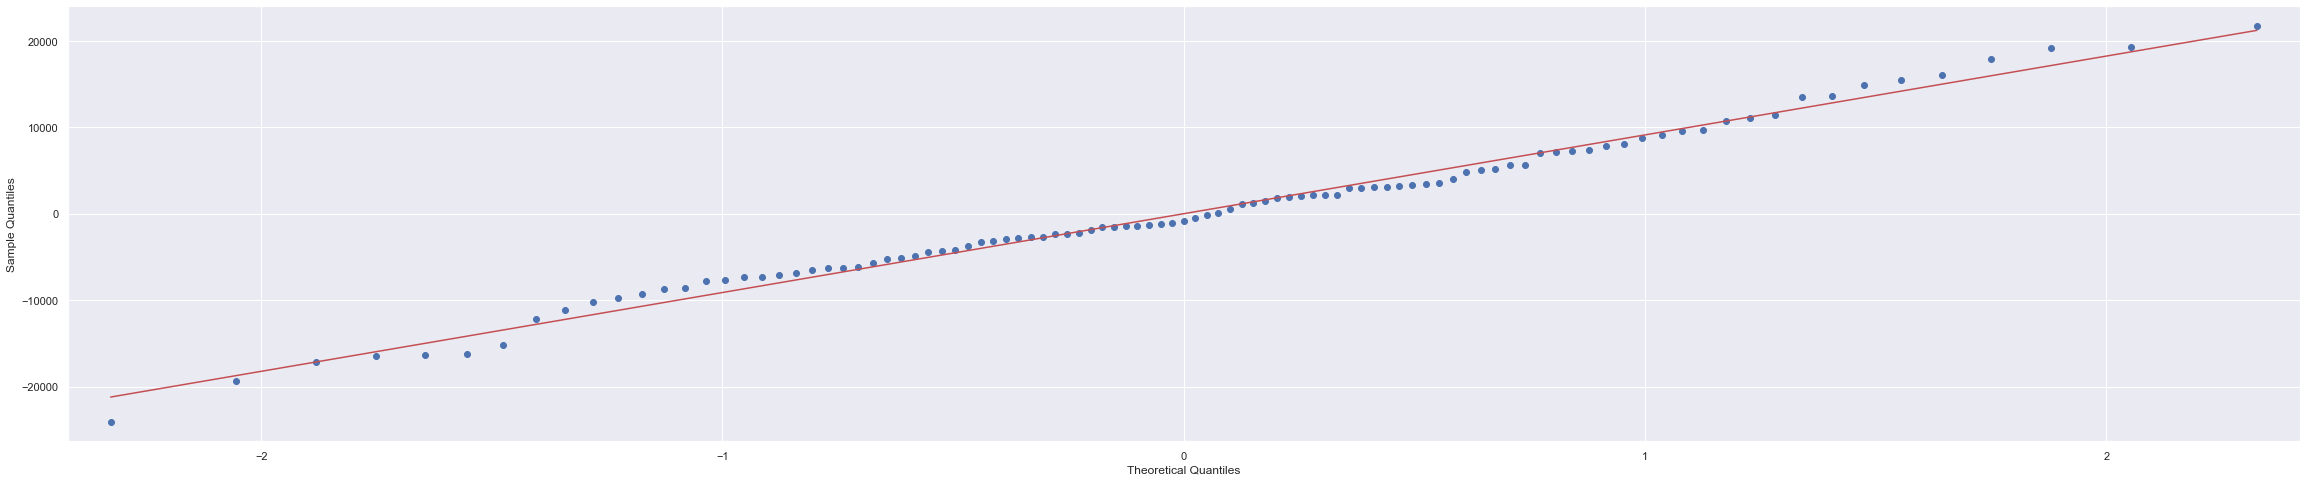

In [67]:
fig = sm.qqplot(residual, line = 'r')
plt.show()
fig.savefig("../data_visualization/Q-Q Plot for In-Sample Fit.png")

In [39]:
residual

1    -16478.349691
2      7782.616026
3     -8578.325026
4     -1450.908917
5      2942.183716
          ...     
95     1867.392139
96     2122.411706
97    -4891.559333
98     -881.779053
99     5041.414268
Length: 99, dtype: float64

In [40]:
sel_x_test = test_x[['Days on Market_1diff', 'US_UR_1diff', 'New Listings MoM_1diff', 'WDXRSA_1diff']]
test_X = sm.add_constant(sel_x_test)
res.predict(test_X)

100     5067.720543
101    -2963.199724
102    -1590.137477
103    -4620.613634
104    -1192.487869
105     -731.791884
106     2536.632697
107    -5421.176852
108    12218.800074
109     5049.707834
110     3126.000365
111     1167.868805
112     4802.112064
113    -1771.908193
114     1080.394179
115    -4509.039538
116     6487.990946
dtype: float64

In [109]:
def MoM_trans(data = residual, ini_value = df['Median Sale Price'][0]):
    pred_y = []
    pred_y.append(ini_value)
    for i in range(len(data)):
        temp = pred_y[i]*(1 - data[i + 1 ]/100)
        pred_y.append(temp)
    return pred_y

In [41]:
def first_diff(data = res.predict(train_X), ini_value = df['Median Sale Price'][0]):
    pred_y = []
    pred_y.append(ini_value)
    for i in range(len(data)):
        temp = pred_y[i] + data[i+1]
        pred_y.append(temp)
    return pred_y

In [42]:
pred_y = first_diff(data = res.predict(train_X), ini_value = df['Median Sale Price'][0])

In [48]:
len(pred_y)

100

In [43]:
train_y = df["Median Sale Price MoM"][1:100]
test_y = df["Median Sale Price MoM"][100:117]

In [44]:
error = df["Median Sale Price"][1:100] - pred_y[1:100]

In [45]:
#MAE
np.mean(abs(error))

10591.326005446646

In [46]:
#MAPE
np.mean(abs(error)/df["Median Sale Price"][1:100])

0.04023299119320409

In [47]:
res.predict(test_X)

100     5067.720543
101    -2963.199724
102    -1590.137477
103    -4620.613634
104    -1192.487869
105     -731.791884
106     2536.632697
107    -5421.176852
108    12218.800074
109     5049.707834
110     3126.000365
111     1167.868805
112     4802.112064
113    -1771.908193
114     1080.394179
115    -4509.039538
116     6487.990946
dtype: float64

In [48]:
residual

1    -16478.349691
2      7782.616026
3     -8578.325026
4     -1450.908917
5      2942.183716
          ...     
95     1867.392139
96     2122.411706
97    -4891.559333
98     -881.779053
99     5041.414268
Length: 99, dtype: float64

In [49]:
temp = res.predict(test_X).reset_index()[0]
temp.index += 1

In [50]:
temp

1      5067.720543
2     -2963.199724
3     -1590.137477
4     -4620.613634
5     -1192.487869
6      -731.791884
7      2536.632697
8     -5421.176852
9     12218.800074
10     5049.707834
11     3126.000365
12     1167.868805
13     4802.112064
14    -1771.908193
15     1080.394179
16    -4509.039538
17     6487.990946
Name: 0, dtype: float64

In [51]:
pred_y_oot = first_diff(data = temp, ini_value = df['Median Sale Price'][100])

In [52]:
len(pred_y_oot)

18

In [53]:
pred_y_oot

[310000.0,
 315067.7205427887,
 312104.52081877185,
 310514.3833416637,
 305893.7697072883,
 304701.2818382476,
 303969.4899541216,
 306506.1226508808,
 301084.94579856115,
 313303.74587269174,
 318353.45370712527,
 321479.4540723685,
 322647.3228774638,
 327449.43494125945,
 325677.5267484337,
 326757.92092728795,
 322248.881389596,
 328736.87233558705]

In [54]:
error_oot = df["Median Sale Price"][100:117] - pred_y_oot[1:18]

In [55]:
np.mean((abs(error_oot)))

7882.9916206589105

In [56]:
np.mean((abs(error_oot))/df["Median Sale Price"][100:117])

0.02608378391243214

In [60]:
df_model = pd.DataFrame(df1['Time'])
df_model['Median Sale Price MoM'] = df['Median Sale Price MoM'][1:117]
df_model['In Time'] = temp #pd.Series(temp, index=df1.index)
df_model['OOT Time'] = df_model['In Time']
df_model.to_csv('../data/df_model.csv')

In [155]:
df_model['In Time'][100:117] = np.NaN
df_model['OOT Time'][0:100] = np.NaN
df_model.to_csv('../data/df_model.csv')

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [156]:
df_model = pd.read_csv('../data/df_model.csv')

In [157]:
#df_model[100:117]
df_model[0:100]

,Unnamed: 0,Time,Median Sale Price MoM,In Time,OOT Time
0,1,2010-Mar,-5.2,5067.720543,NaN
1,2,2010-Apr,9.7,-2963.199724,NaN
2,3,2010-May,-3.8,-1590.137477,NaN
3,4,2010-Jun,-4.0,-4620.613634,NaN
4,5,2010-Jul,0.0,-1192.487869,NaN
...,...,...,...,...,...
95,96,2018-Feb,4.0,NaN,NaN
96,97,2018-Mar,1.2,NaN,NaN
97,98,2018-Apr,1.8,NaN,NaN
98,99,2018-May,0.4,NaN,NaN


In [31]:
df_model['yearmo'] = pd.to_datetime(df_model['Time'])
testdf = df_model.set_index('yearmo')
testdf

,Unnamed: 0,Time,Median Sale Price MoM,In Time,OOT Time
yearmo,,,,,
2010-03-01,1,2010-Mar,-5.2,0.173916,NaN
2010-04-01,2,2010-Apr,9.7,4.977420,NaN
2010-05-01,3,2010-May,-3.8,1.007147,NaN
2010-06-01,4,2010-Jun,-4.0,-3.202927,NaN
2010-07-01,5,2010-Jul,0.0,-1.399629,NaN
...,...,...,...,...,...
2019-06-01,112,2019-Jun,2.5,NaN,3.753112
2019-07-01,113,2019-Jul,-2.2,NaN,-0.956970
2019-08-01,114,2019-Aug,-5.7,NaN,-0.415322


In [37]:
df_model

,Unnamed: 0,Time,Median Sale Price MoM,In Time,OOT Time,yearmo
0,1,2010-Mar,-5.2,0.173916,NaN,2010-03-01
1,2,2010-Apr,9.7,4.977420,NaN,2010-04-01
2,3,2010-May,-3.8,1.007147,NaN,2010-05-01
3,4,2010-Jun,-4.0,-3.202927,NaN,2010-06-01
4,5,2010-Jul,0.0,-1.399629,NaN,2010-07-01
...,...,...,...,...,...,...
111,112,2019-Jun,2.5,NaN,3.753112,2019-06-01
112,113,2019-Jul,-2.2,NaN,-0.956970,2019-07-01
113,114,2019-Aug,-5.7,NaN,-0.415322,2019-08-01
114,115,2019-Sep,5.0,NaN,-3.523594,2019-09-01


In [29]:
ax2 = sns.lineplot(x = df_model['yearmo'][1:100], y = df_model['In Time'][1:100], color = 'g')
ax2.xaxis_date()
ax3 = sns.lineplot(x = df_model['yearmo'][100:117], y = df_model['OOT Time'][100:117], color = 'b')
ax3.xaxis_date()
ax4 = sns.lineplot(x = df_model["yearmo"], y = df_model["Median Sale Price MoM"], color = 'r')
ax4.xaxis_date()

sns.set(rc={'figure.figsize':(40,8)})
plt.xticks(range(0, 130, 10))
plt.title("Prediction House Price MoM", fontsize = 40)
plt.xlabel("Month", fontsize = 30)
plt.ylabel("Condo Sale Price MoM", fontsize = 30)
plt.show()

ValueError: DateFormatter found a value of x=0, which is an illegal date; this usually occurs because you have not informed the axis that it is plotting dates, e.g., with ax.xaxis_date()

<Figure size 2880x576 with 1 Axes>

### Create a dataset for plot

In [57]:
temp

1      5067.720543
2     -2963.199724
3     -1590.137477
4     -4620.613634
5     -1192.487869
6      -731.791884
7      2536.632697
8     -5421.176852
9     12218.800074
10     5049.707834
11     3126.000365
12     1167.868805
13     4802.112064
14    -1771.908193
15     1080.394179
16    -4509.039538
17     6487.990946
Name: 0, dtype: float64

In [58]:
temp = pred_y + pred_y_oot[1:18]
type(temp)
temp = pd.Series(temp)

In [59]:
df_temp = pd.read_csv("../data/full_data.csv")
df_predict = pd.DataFrame(df_temp['Time'])
df_predict["Median Sale Price"] = df["Median Sale Price"]
df_predict['In Time'] = pd.Series(temp, index=df1.index)
df_predict['OOT Time'] = df_predict['In Time']
df_predict = df_predict[0:117]
df_predict['In Time'][100:117] = np.NaN
df_predict['OOT Time'][0:100] = np.NaN
df_predict.to_csv('../data/df_predict.csv')

In [271]:
df_temp

,Time,Median Sale Price,Median Sale Price MoM,Homes Sold,Homes Sold MoM,New Listings,New Listings MoM,Inventory,Inventory MoM,Days on Market,...,WDXRSA,US_UR,DMV_UR,DC_UR,FED_EM,FIN_EM,HOS_EM,DC_PER,DMV_PER,DMV_PER_1
0,2010-Feb,250000.0,11.1,521.0,-3.9,1085.0,-2.3,3346.0,6.5,51,...,180.451677,9.8,6.9,9.7,373.444291,96.646081,254.227222,60.0,1447.651302,821.847524
1,2010-Mar,237000.0,-5.2,786.0,50.9,1681.0,54.9,3670.0,9.7,42,...,179.886193,9.9,6.7,9.5,373.911092,96.916094,258.398701,27.0,1194.393163,732.449501
2,2010-Apr,260000.0,9.7,909.0,15.6,1719.0,2.3,3892.0,6.0,28,...,181.982940,9.9,6.1,9.4,375.438325,96.709393,262.204679,166.0,1240.543680,792.792527
3,2010-May,250000.0,-3.8,988.0,8.7,1029.0,-40.1,3874.0,-0.5,30,...,182.983985,9.6,6.3,9.3,384.432209,96.954287,259.995404,15.0,1068.784557,646.662505
4,2010-Jun,240000.0,-4.0,962.0,-2.6,1260.0,22.4,3907.0,0.9,35,...,183.939947,9.4,6.5,9.3,383.827749,97.197389,261.043229,8.0,1167.185307,768.646617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2019-Jun,325000.0,2.5,1089.0,-9.3,1162.0,-20.2,1752.0,0.2,20,...,232.112524,3.7,3.4,5.6,363.193444,103.253989,347.332822,389.0,2036.740005,1178.709018
113,2019-Jul,318000.0,-2.2,1094.0,0.5,1172.0,0.9,1694.0,-3.3,22,...,232.032415,3.7,3.3,5.6,363.391729,102.106994,347.357406,455.0,2056.199932,1138.927749
114,2019-Aug,300000.0,-5.7,1074.0,-1.8,972.0,-17.1,1540.0,-9.1,25,...,232.650097,3.7,3.2,5.5,364.342848,102.964051,350.489560,437.0,2000.434352,1247.029523
115,2019-Sep,315000.0,5.0,888.0,-17.3,1218.0,25.3,1692.0,9.9,25,...,233.380305,3.5,2.9,5.4,363.321499,102.012584,352.846320,329.0,2083.453745,1429.372493


In [259]:
df_predict[0:100]
df_predict[99:117]
#df_predict

,Time,Median Sale Price,In Time,OOT Time
99,2018-May,311000.0,311000.0,NaN
100,2018-Jun,310000.0,NaN,315067.720543
101,2018-Jul,303000.0,NaN,312104.520819
102,2018-Aug,291000.0,NaN,310514.383342
103,2018-Sep,300000.0,NaN,305893.769707
104,2018-Oct,299000.0,NaN,304701.281838
105,2018-Nov,290000.0,NaN,303969.489954
106,2018-Dec,307000.0,NaN,306506.122651
107,2019-Jan,300000.0,NaN,301084.945799
108,2019-Feb,300000.0,NaN,313303.745873


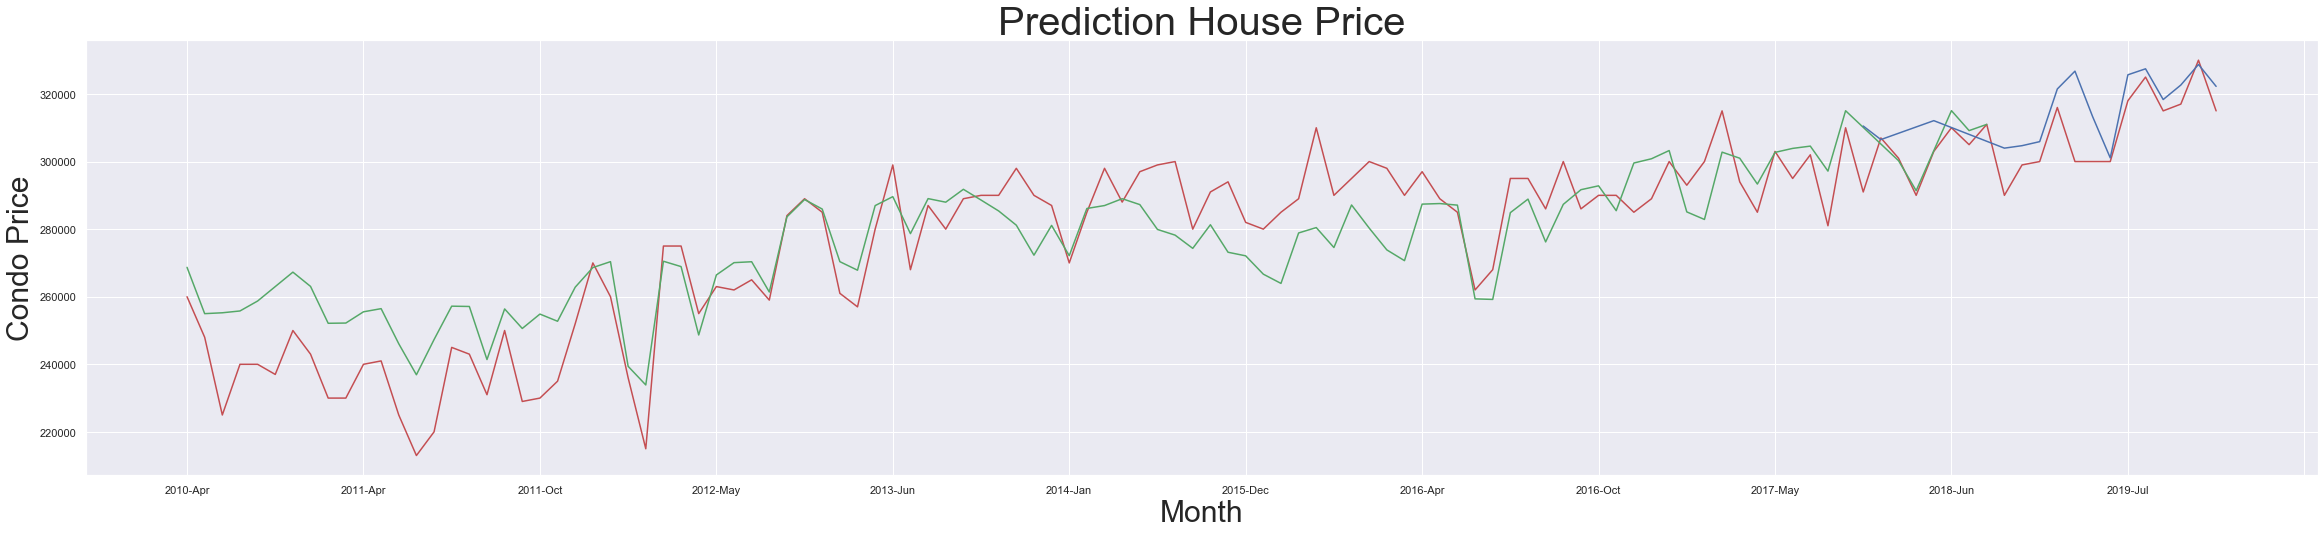

In [166]:
sns.lineplot(x = "Time", y = "Median Sale Price", color = 'r', data = df_predict)
ax2 = sns.lineplot(x = "Time", y = "In Time", color = 'g', data = df_predict[1:100])
ax3 = sns.lineplot(x = "Time", y = "OOT Time", color = 'b', data = df_predict[100:117])
sns.set(rc={'figure.figsize':(40,8)})
plt.xticks(range(0, 130, 10))
plt.title("Prediction House Price", fontsize = 40)
plt.xlabel("Month", fontsize = 30)
plt.ylabel("Condo Price", fontsize = 30)
plt.show()


In [181]:
df_predict[["Median Sale Price", "In Time", "OOT Time"]]

,Median Sale Price,In Time,OOT Time
1,237000.0,253478.349691,253478.349691
2,260000.0,268695.733664,NaN
3,250000.0,267274.058690,NaN
4,240000.0,258724.967606,NaN
5,240000.0,255782.783891,NaN
...,...,...,...
112,325000.0,NaN,327449.434941
113,318000.0,NaN,325677.526748
114,300000.0,NaN,326757.920927
115,315000.0,NaN,322248.881390


In [60]:
index = pd.date_range("2 1 2010", periods=117,
                      freq="m", name="date")
data_temp = df_predict[["Median Sale Price", "In Time", "OOT Time"]]
predict_m = pd.DataFrame(data_temp, index)

In [61]:
predict_m["Median Sale Price"] = np.array(df["Median Sale Price"])
predict_m["In Time"] = np.array(temp)
predict_m["OOT Time"] = np.array(temp)
predict_m['In Time'][100:117] = np.NaN
predict_m['OOT Time'][0:100] = np.NaN
predict_m.to_csv('../data/predict_m.csv')

In [3]:
predict_m = pd.read_csv('../data/predict_m.csv')

In [66]:
predict_m

,Median Sale Price,In Time,OOT Time
date,,,
2010-02-28,250000.0,250000.000000,NaN
2010-03-31,237000.0,253478.349691,NaN
2010-04-30,260000.0,268695.733664,NaN
2010-05-31,250000.0,267274.058690,NaN
2010-06-30,240000.0,258724.967606,NaN
...,...,...,...
2019-06-30,325000.0,NaN,327449.434941
2019-07-31,318000.0,NaN,325677.526748
2019-08-31,300000.0,NaN,326757.920927


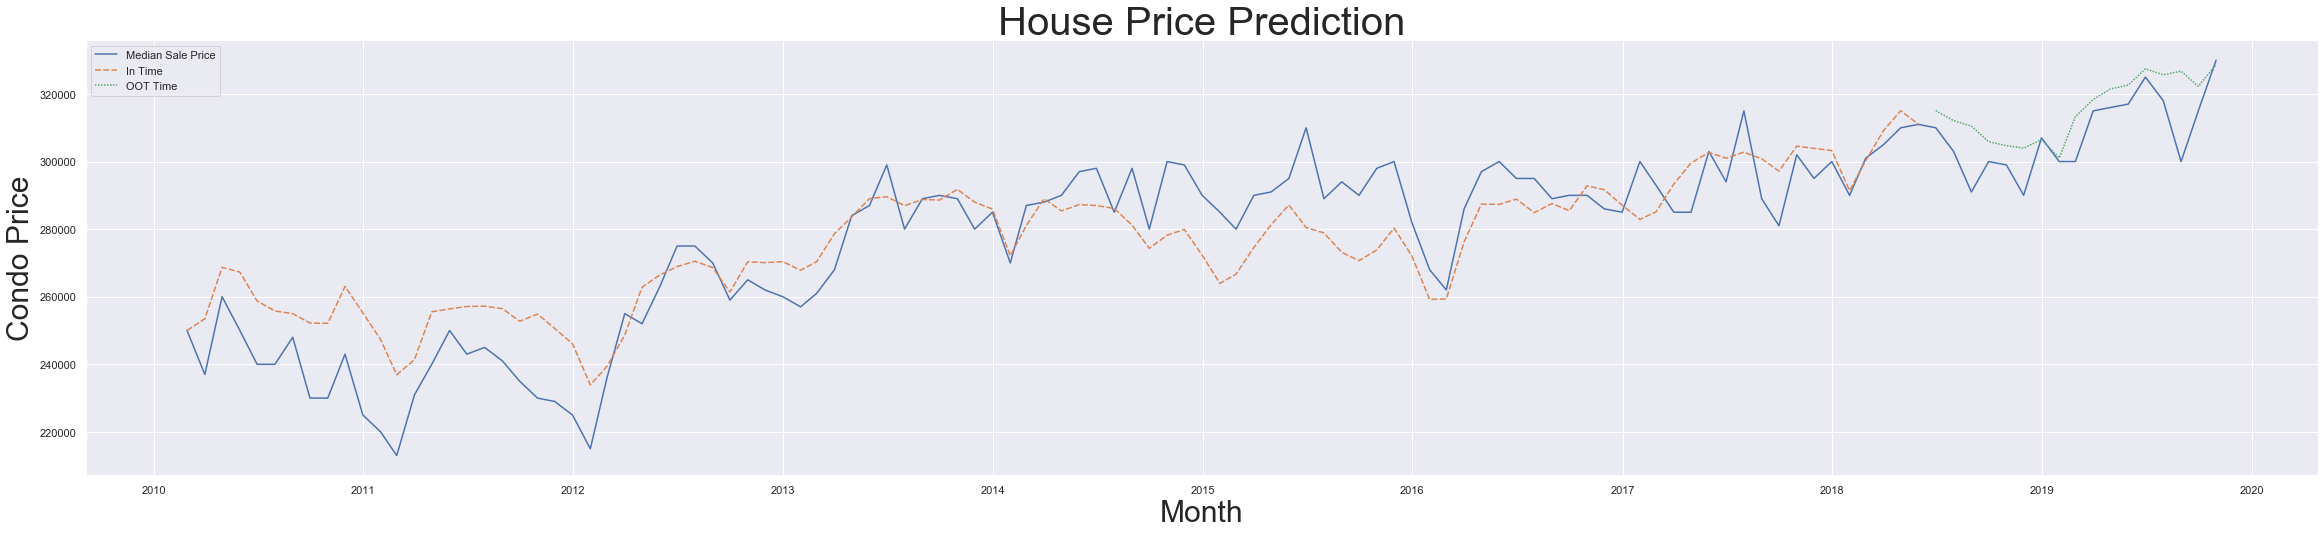

In [66]:
list_data = [predict_m.loc[:, "Median Sale Price"], predict_m.loc[:"5 31 2018", "In Time"], predict_m.loc["6 1 2018":, "OOT Time"]]
ax = sns.lineplot(data=list_data, legend="full")
sns.set(rc={'figure.figsize':(40,8)})
plt.title("House Price Prediction", fontsize = 40)
plt.xlabel("Month", fontsize = 30)
plt.ylabel("Condo Price", fontsize = 30)
plt.show()
ax.figure.savefig("../data_visualization/Model_Performance.png")
#ax.savefig("../data_visualization/Model_Performance.png")

In [ ]:
res.model.exog
het_breuschpagan(residual, res.model.exog)

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(residual, res.model.exog)
lzip(name, test)

In [ ]:
name = ['F statistic', 'p-value']
test = het_goldfeldquandt(residual, res.model.exog)
lzip(name, test)